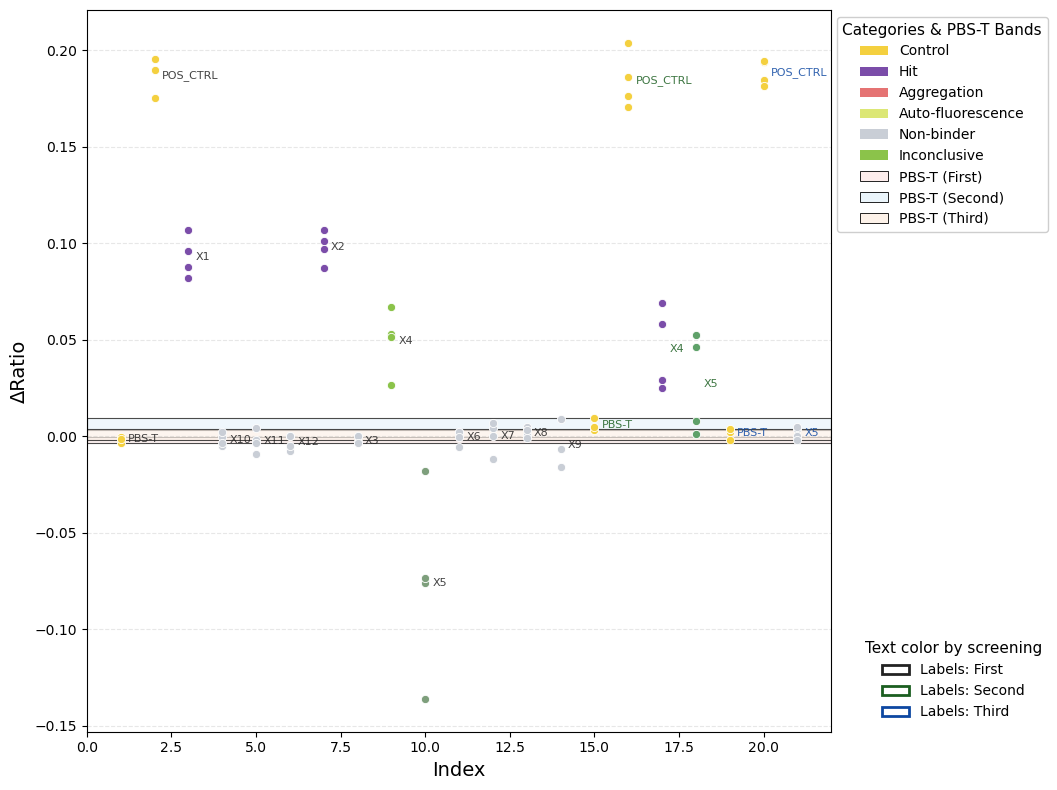

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

tbl1 = Path("table first screening.xlsx")
tbl2 = Path("table second screening.xlsx")
tbl3 = Path("table third screening.xlsx")
ov1  = Path("first screening overview.xlsx")
ov2  = Path("second screening overview.xlsx")
ov3  = Path("third screening overview.xlsx")

def lig_cat_map(overview: pd.DataFrame) -> dict:
    df = overview.copy()
    df = df[df["Ligand Information"].notna()]
    df = df[df["Ligand Information"] != "Name"]
    df = df[~df["Ligand Information"].astype(str).str.contains("Data Point", na=False)]
    return dict(zip(df["Ligand Information"].astype(str).str.strip(),
                    df["Analysis Results"].astype(str).str.strip()))

def excluded_wells(overview: pd.DataFrame) -> set:
    df = overview.copy()
    mask_dp = df["Ligand Information"].astype(str).str.startswith("Data Point", na=False)
    df = df[mask_dp]
    well_col = "Unnamed: 2" if "Unnamed: 2" in df.columns else "Well"
    detail_col = "Unnamed: 4" if "Unnamed: 4" in df.columns else "Details"
    excl = df[df[detail_col].astype(str).str.contains("Excluded", case=False, na=False)]
    wells = []
    for w in excl[well_col].dropna().astype(str).tolist():
        for part in w.split(","):
            wells.append(part.strip())
    return set(wells)

def add_point_categories(df: pd.DataFrame, cmap: dict, screening_name: str) -> pd.DataFrame:
    out = df.copy()
    out["Screening"] = screening_name
    out["Ligand_clean"] = out["Ligand"].astype(str).str.strip()
    out["PointCategory"] = out["Ligand_clean"].map(cmap)
    out.loc[out["Ligand_clean"].isin(["PBS-T", "POS_CTRL"]), "PointCategory"] = "Control"
    return out

def pb_range(df: pd.DataFrame):
    pb = df[df["Ligand_clean"] == "PBS-T"]["Ratio"].dropna()
    return (pb.min(), pb.max()) if len(pb) else None

t1 = pd.read_excel(tbl1, sheet_name="Table")
t2 = pd.read_excel(tbl2, sheet_name="Table")
t3 = pd.read_excel(tbl3, sheet_name="Table")
o1 = pd.read_excel(ov1)
o2 = pd.read_excel(ov2)
o3 = pd.read_excel(ov3)

m1 = lig_cat_map(o1); m2 = lig_cat_map(o2); m3 = lig_cat_map(o3)
ex1 = excluded_wells(o1); ex2 = excluded_wells(o2); ex3 = excluded_wells(o3)

t1 = add_point_categories(t1, m1, "First")
t2 = add_point_categories(t2, m2, "Second")
t3 = add_point_categories(t3, m3, "Third")

t1 = t1[~t1["Well ID"].astype(str).isin(ex1)]
t2 = t2[~t2["Well ID"].astype(str).isin(ex2)]
t3 = t3[~t3["Well ID"].astype(str).isin(ex3)]

r1 = pb_range(t1); r2 = pb_range(t2); r3 = pb_range(t3)

screen_order = ["First", "Second", "Third"]
allp = pd.concat([t1, t2, t3], ignore_index=True)

allp = allp[allp["Ligand_clean"].str.match(r"^(X\d+|PBS-T|POS_CTRL)$", na=False)].copy()

allp["Screening"] = pd.Categorical(allp["Screening"], categories=screen_order, ordered=True)
allp["dRatio"] = allp["Ratio"] - 1.0
allp = allp.sort_values(["Screening", "Ligand_clean"]).reset_index(drop=True)

# stable x-position per (Screening, Ligand)
allp["Xpos"] = allp.groupby(["Screening", "Ligand_clean"], observed=True).ngroup() + 1

cat_colors = {
    "Control": "#F4D03F", "Hit": "#7B4DA9", "Non-binder": "#C9CED6",
    "Inhomogeneous Signal": "#5FA169", "Scan Anomaly": "#7E9F7C",
    "Inconclusive": "#8BC34A", "Aggregation": "#E57373", "Excluded": "#616161",
}
label_colors = {"First": "#222222", "Second": "#1B5E20", "Third": "#0D47A1"}
band_colors  = {"First":"#FDEDEC", "Second":"#EBF5FB", "Third":"#FDF2E9"}

fig, ax = plt.subplots(figsize=(11, 8))

def add_band(rng_pair, color, label):
    if rng_pair:
        ax.axhspan(rng_pair[0] - 1.0, rng_pair[1] - 1.0,
                   facecolor=color, alpha=0.7, zorder=0,
                   edgecolor="black", linewidth=0.8, label=label)

add_band(r1, band_colors["First"],  "PBS-T area (First)")
add_band(r2, band_colors["Second"], "PBS-T area (Second)")
add_band(r3, band_colors["Third"],  "PBS-T area (Third)")

for _, r in allp.iterrows():
    c = cat_colors.get(r["PointCategory"], "#9E9E9E")
    ax.scatter(r["Xpos"], r["dRatio"], s=35, color=c,
               edgecolor="white", linewidth=0.6, marker="o", zorder=3)

# label once per (Screening, Ligand)
label_df = (
    allp.groupby(["Screening", "Ligand_clean"], observed=True)[["Xpos", "dRatio"]]
        .agg({"Xpos": "first", "dRatio": "mean"})
        .rename(columns={"dRatio": "dRatio_mean"})
        .reset_index()
)

for _, row in label_df.iterrows():
    ax.text(row["Xpos"] + 0.22, row["dRatio_mean"], row["Ligand_clean"],
            fontsize=8, alpha=0.85,
            color=label_colors.get(str(row["Screening"]), "black"),
            va="center")

ax.set_xlabel("Index", fontsize=14)
ax.set_ylabel("ΔRatio", fontsize=14)

cat_handles = [
    Patch(facecolor=cat_colors["Control"], edgecolor="none", label="Control"),
    Patch(facecolor=cat_colors["Hit"], edgecolor="none", label="Hit"),
    Patch(facecolor=cat_colors["Aggregation"], edgecolor="none", label="Aggregation"),
    Patch(facecolor="#DCE775", edgecolor="none", label="Auto-fluorescence"),
    Patch(facecolor=cat_colors["Non-binder"], edgecolor="none", label="Non-binder"),
    Patch(facecolor=cat_colors["Inconclusive"], edgecolor="none", label="Inconclusive"),
    Patch(facecolor=band_colors["First"], edgecolor="black", linewidth=0.6, label="PBS-T (First)"),
    Patch(facecolor=band_colors["Second"], edgecolor="black", linewidth=0.6, label="PBS-T (Second)"),
    Patch(facecolor=band_colors["Third"], edgecolor="black", linewidth=0.6, label="PBS-T (Third)"),
]
leg1 = ax.legend(handles=cat_handles, loc="upper right", bbox_to_anchor=(1.30, 1.0),
                 fontsize=10, frameon=True, framealpha=0.95,
                 title="Categories & PBS-T Bands", title_fontsize=11)
screen_handles = [Patch(facecolor="white", edgecolor=label_colors[s], label=f"Labels: {s}", linewidth=2)
                  for s in ["First", "Second", "Third"]]
leg2 = ax.legend(handles=screen_handles, loc="lower right", bbox_to_anchor=(1.30, 0.0),
                 fontsize=10, frameon=False, title="Text color by screening", title_fontsize=11)
ax.add_artist(leg1)

ax.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()

plt.savefig("ratio_scatter_all_screenings_overlapping.png", dpi=300, bbox_inches="tight")
plt.savefig("ratio_scatter_all_screenings_overlapping.pdf", dpi=300, bbox_inches="tight")
plt.show()